# VinBigData Chest X-ray: Training [2/3]

This Jupyter Notebook is part of a series of notebooks for visualizing / Training / Testing  of  the VinBigData Chest X-ray dataset. In this notebook, we will explore various Training methods to get the best results.

# Import necessary libraries

Imports essential Python libraries for data manipulation and mathematical operations, specifically NumPy and pandas.

In [4]:

#  Data Science Imports
import numpy as np
import pandas as pd

# ---Built In Imports---
from pathlib import Path
import sys, os, distutils.core
import os
from tqdm.notebook import tqdm
from IPython.display import display, HTML
import subprocess

# --- Visualisation Imports  ---
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.io as pio
pio.templates.default = "plotly_dark"
import matplotlib.pyplot as plt


# Set up envirement

Runs shell commands to check the NVIDIA System Management Interface (nvidia-smi) and the CUDA compiler version (nvcc --version), providing information about the GPU and CUDA toolkit available on the system.

In [5]:
!nvidia-smi
!nvcc --version

Sat Mar 16 00:05:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.09                 Driver Version: 546.09       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8               2W /  60W |   1282MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Python Package Installation

Installs a specific version of PyYAML, a library for YAML parsing and output, ensuring compatibility with other packages or scripts in the notebook.

In [6]:
!python -m pip install pyyaml==5.1

# Setup Detectron2

Runs the setup script for Detectron2, installing it along with its dependencies. This step is crucial for ensuring that Detectron2 is correctly installed and its functionalities are accessible within the notebook.

In [7]:
!git clone https://github.com/facebookresearch/detectron2

fatal: destination path 'detectron2' already exists and is not an empty directory.


In [8]:
dist = distutils.core.run_setup("./detectron2/setup.py")
required_packages = dist.install_requires
print(required_packages)

c:\Users\elkar\Downloads\Test\.venv\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning:

Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.



['Pillow>=7.1', 'matplotlib', 'pycocotools>=2.0.2', 'termcolor>=1.1', 'yacs>=0.1.8', 'tabulate', 'cloudpickle', 'tqdm>4.29.0', 'tensorboard', 'fvcore<0.1.6,>=0.1.5', 'iopath<0.1.10,>=0.1.7', 'omegaconf<2.4,>=2.1', 'hydra-core>=1.1', 'black', 'packaging']


In [9]:
# Function to install packages using pip
def install_packages(packages):
    subprocess.check_call([sys.executable, "-m", "pip", "install"] + packages)

# Call the function with the list of required packages
install_packages(required_packages)


In [10]:
sys.path.insert(0, os.path.abspath('./detectron2'))

# Test Proper Installation

Ensure that the necessary libraries are installed and configured correctly, and to verify that the GPU can be used for computation.

In [11]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)


print(f"CUDA Available: {torch.cuda.is_available()}")
print("detectron2:", detectron2.__version__)


if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Device Name: {torch.cuda.get_device_name(0)}")

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Feb__8_05:53:42_Coordinated_Universal_Time_2023
Cuda compilation tools, release 12.1, V12.1.66
Build cuda_12.1.r12.1/compiler.32415258_0
torch:  2.2 ; cuda:  cu121
CUDA Available: True
detectron2: 0.6
CUDA Version: 12.1
Device Name: NVIDIA GeForce RTX 4060 Laptop GPU


# Utility Imports

In [12]:
import cv2
from detectron2.structures import BoxMode
from tqdm import tqdm
import pickle
from typing import Dict, Optional
import yaml
import dataclasses
from detectron2.utils.logger import setup_logger
from detectron2.data import DatasetCatalog, MetadataCatalog
from dataclasses import dataclass, field
from random import seed


setup_logger()


<Logger detectron2 (DEBUG)>

# Flags Dataclass Definition

Define a data class to manage flags or configurations, which are variables that control the behavior of the script or model training.

In [41]:
# Define the Flags dataclass
@dataclass
class Flags:
    debug: bool = True
    outdir: str = "results/det"
    imgdir_name: str = "train"
    split_mode: str = "all_train"
    seed: int = 111
    train_data_type: str = "original"
    use_class14: bool = False
    iter: int = 10000
    ims_per_batch: int = 2
    num_workers: int = 4
    lr_scheduler_name: str = "WarmupMultiStepLR"
    base_lr: float = 0.00025
    roi_batch_size_per_image: int = 512
    eval_period: int =  10000
    aug_kwargs: Dict = field(default_factory=lambda: {})

    def update(self, param_dict: Dict) -> "Flags":
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self



# Efficient Data Handling for Detectron2

Streamline the process of working with datasets in Detectron2 for object detection tasks. From saving configuration settings, loading and preprocessing images and annotations, to managing dataset registrations within Detectron2's ecosystem, these functions offer a comprehensive toolkit for dataset handling. Whether you're setting up your dataset for the first time, adjusting preprocessing steps, or ensuring your training and validation splits are correctly configured, this cell lays the groundwork for efficient and effective data management in your Detectron2 projects.

In [42]:
def save_yaml(filepath, content):
    with open(filepath, "w") as f:
        yaml.dump(content, f)

# Function to load and preprocess the dataset
def load_data(
    imgdir: Path,
    train_df: pd.DataFrame,
    train_data_type: str = "original",
    use_cache: bool = True,
    debug: bool = True,
    target_indices: Optional[np.ndarray] = None,
    use_class14: bool = False,
):
    cache_path = Path(".") / "dataset_dicts_cache.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        train_meta = pd.read_csv(imgdir / "Original_Image_Dimensions.csv")
        if debug:
            train_meta = train_meta.iloc[:500]

        dataset_dicts = []
        for index, train_meta_row in tqdm(train_meta.iterrows(), total=len(train_meta)):
            record = {}
            image_id, height, width = train_meta_row.values
            filename = str(imgdir / "train" / f"{image_id}.png")
            image = cv2.imread(filename)
            resized_height, resized_width, _ = image.shape

            record["file_name"] = filename
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width

            objs = []
            for _, row in train_df.query("image_id == @image_id").iterrows():
                class_id = row["class_id"]
                if class_id == 14 and not use_class14:
                    continue
                
                bbox_resized = [
                    float(row["x_min"]) * (resized_width / width),
                    float(row["y_min"]) * (resized_height / height),
                    float(row["x_max"]) * (resized_width / width),
                    float(row["y_max"]) * (resized_height / height),
                ]
                obj = {
                    "bbox": bbox_resized,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": class_id,
                }
                objs.append(obj)

            record["annotations"] = objs
            dataset_dicts.append(record)

        with open(cache_path, "wb") as f:
            pickle.dump(dataset_dicts, f)
    else:
        print(f"Loading dataset_dicts from cache {cache_path}")
        with open(cache_path, "rb") as f:
            dataset_dicts = pickle.load(f)

    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]

    return dataset_dicts


def save_datasets(flags: Flags, train_df: pd.DataFrame, thing_classes: list):
    """
    Registers the datasets with Detectron2's DatasetCatalog and MetadataCatalog based on split_mode.
    """
    imgdir = Path("Proc_data")

    if flags.split_mode == "all_train":
        # Register the entire dataset as training data
        DatasetCatalog.register(
            "vinbigdata_train", 
            lambda: load_data(imgdir, train_df, flags.train_data_type, flags.debug, flags.use_class14)
        )
        MetadataCatalog.get("vinbigdata_train").set(thing_classes=thing_classes)

    elif flags.split_mode == "valid20":
        # Randomly split the dataset into training and validation sets (80% training, 20% validation)
        dataset_dicts = load_data(imgdir, train_df, flags.train_data_type, False, flags.use_class14)  # Force no cache
        n_dataset = len(dataset_dicts)
        n_train = int(n_dataset * 0.8)
        print("n_dataset:", n_dataset, "n_train:", n_train)
        
        rs = np.random.RandomState(flags.seed)
        inds = rs.permutation(n_dataset)
        train_inds, valid_inds = inds[:n_train], inds[n_train:]

        # Register training dataset
        DatasetCatalog.register(
            "vinbigdata_train",
            lambda: [dataset_dicts[i] for i in train_inds]
        )
        MetadataCatalog.get("vinbigdata_train").set(thing_classes=thing_classes)
        
        # Register validation dataset
        DatasetCatalog.register(
            "vinbigdata_valid",
            lambda: [dataset_dicts[i] for i in valid_inds]
        )
        MetadataCatalog.get("vinbigdata_valid").set(thing_classes=thing_classes)

    else:
        raise ValueError(f"[ERROR] Unexpected value split_mode={flags.split_mode}")
    
def remove_existing_dataset(dataset_name):
    """
    Removes an existing dataset registration from Detectron2's DatasetCatalog and MetadataCatalog.
    """
    if dataset_name in DatasetCatalog.list():
        DatasetCatalog.remove(dataset_name)
        print(f"Removed existing dataset registration for '{dataset_name}'.")
    if dataset_name in MetadataCatalog.list():
        MetadataCatalog.remove(dataset_name)
        print(f"Removed existing metadata for '{dataset_name}'.")

def print_dataset_element(dataset_name):
    # Retrieve the dataset
    dataset_dicts = DatasetCatalog.get(dataset_name)
    if dataset_dicts:  # Ensure the dataset is not empty
        # Print the first element
        print(f"First element of {dataset_name}:")
        print(dataset_dicts[2999])
    else:
        print(f"Dataset {dataset_name} is empty or not properly registered.")



# Flags Update and Conditional Logic

Updates the flags based on previously defined dictionaries and includes conditional logic based on the flags, possibly affecting the training process.

In [43]:
# Define your flags and configuration here
flags_dict = {
    "debug": True,  # Set to False for full dataset
    "outdir": "results/det",
    "imgdir_name": "data",
    "split_mode": "valid20",
    "iter": 10000,  # For debugging, set a small value
    "roi_batch_size_per_image": 512,  # Faster, and good enough for this toy dataset
    "eval_period": 10000,
    "lr_scheduler_name": "WarmupCosineLR",
    "base_lr": 0.001,
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5}
    }
}

thing_classes = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis"
]

# Configuration Setup

Sets initial flags or configurations for the training, including debug modes and dataset specifications.

In [44]:
flags = Flags()
flags.update(flags_dict)
if flags.use_class14:
    thing_classes.append("No finding")


remove_existing_dataset("vinbigdata_train")
remove_existing_dataset("vinbigdata_valid")


Removed existing dataset registration for 'vinbigdata_train'.
Removed existing metadata for 'vinbigdata_train'.
Removed existing dataset registration for 'vinbigdata_valid'.
Removed existing metadata for 'vinbigdata_valid'.


In [45]:
# Prepare output directory and save configuration
outdir = Path(flags.outdir)
os.makedirs(outdir, exist_ok=True)
save_yaml(outdir / "flags.yaml", dataclasses.asdict(flags))

# Load dataset and register datasets based on the split_mode
train_df = pd.read_csv('Proc_data/train.csv')  
save_datasets(flags, train_df, thing_classes)

Creating data...


100%|██████████| 15000/15000 [00:46<00:00, 322.97it/s]

n_dataset: 15000 n_train: 12000


In [46]:
print_dataset_element("vinbigdata_train")
print_dataset_element("vinbigdata_valid")

First element of vinbigdata_train:
{'file_name': 'Proc_data\\train\\cf52f309aeabc516b79a22632a856b01.png', 'image_id': 'cf52f309aeabc516b79a22632a856b01', 'height': 256, 'width': 256, 'annotations': []}
First element of vinbigdata_valid:
{'file_name': 'Proc_data\\train\\e2aac840e7e6f54e6fe0003c60c51c57.png', 'image_id': 'e2aac840e7e6f54e6fe0003c60c51c57', 'height': 256, 'width': 256, 'annotations': [{'bbox': [174.34771241830063, 60.35010673985971, 224.20915032679736, 160.12686794754498], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 7}, {'bbox': [53.793464052287575, 47.23391277828606, 109.42745098039215, 137.1735285147911], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 4}, {'bbox': [131.59738562091502, 62.301921317474836, 162.3843137254902, 90.56419640134187], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}, {'bbox': [21.667973856209148, 39.114364135407136, 52.87320261437908, 94.0774626410491], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 9}, {'bbox': [160.1254901

# Overlap Check Function

Defines a function to check for overlap between training and validation datasets, ensuring the datasets are properly separated.

In [47]:
def check_overlap(train_dataset, valid_dataset):
    train_ids = {d["image_id"] for d in train_dataset}
    valid_ids = {d["image_id"] for d in valid_dataset}
    overlap = train_ids.intersection(valid_ids)
    if overlap:
        print(f"Overlap found in {len(overlap)} elements.")
    else:
        print("No overlap between training and validation datasets.")

# Assuming you have dataset_dicts for training and validation loaded:
train_dataset = DatasetCatalog.get("vinbigdata_train")
valid_dataset = DatasetCatalog.get("vinbigdata_valid")

check_overlap(train_dataset, valid_dataset)


No overlap between training and validation datasets.


# Dataset Sizes Printing

Function to Print the sizes of specified datasets, providing an overview of the data quantity for training, validation, and testing.

In [50]:
def print_dataset_sizes(dataset_names):
    for dataset_name in dataset_names:
        dataset = DatasetCatalog.get(dataset_name)
        print(f"The dataset '{dataset_name}' contains {len(dataset)} elements.")

# Specify the names of your datasets
dataset_names = ["vinbigdata_train", "vinbigdata_valid"]

# Call the function to print the sizes
print_dataset_sizes(dataset_names)

The dataset 'vinbigdata_train' contains 12000 elements.
The dataset 'vinbigdata_valid' contains 3000 elements.


# Data Visualization 

Visualize prepared training dataset with visualization tools from Detectron2, used for displaying images, annotations

Loading dataset_dicts from cache dataset_dicts_cache.pkl


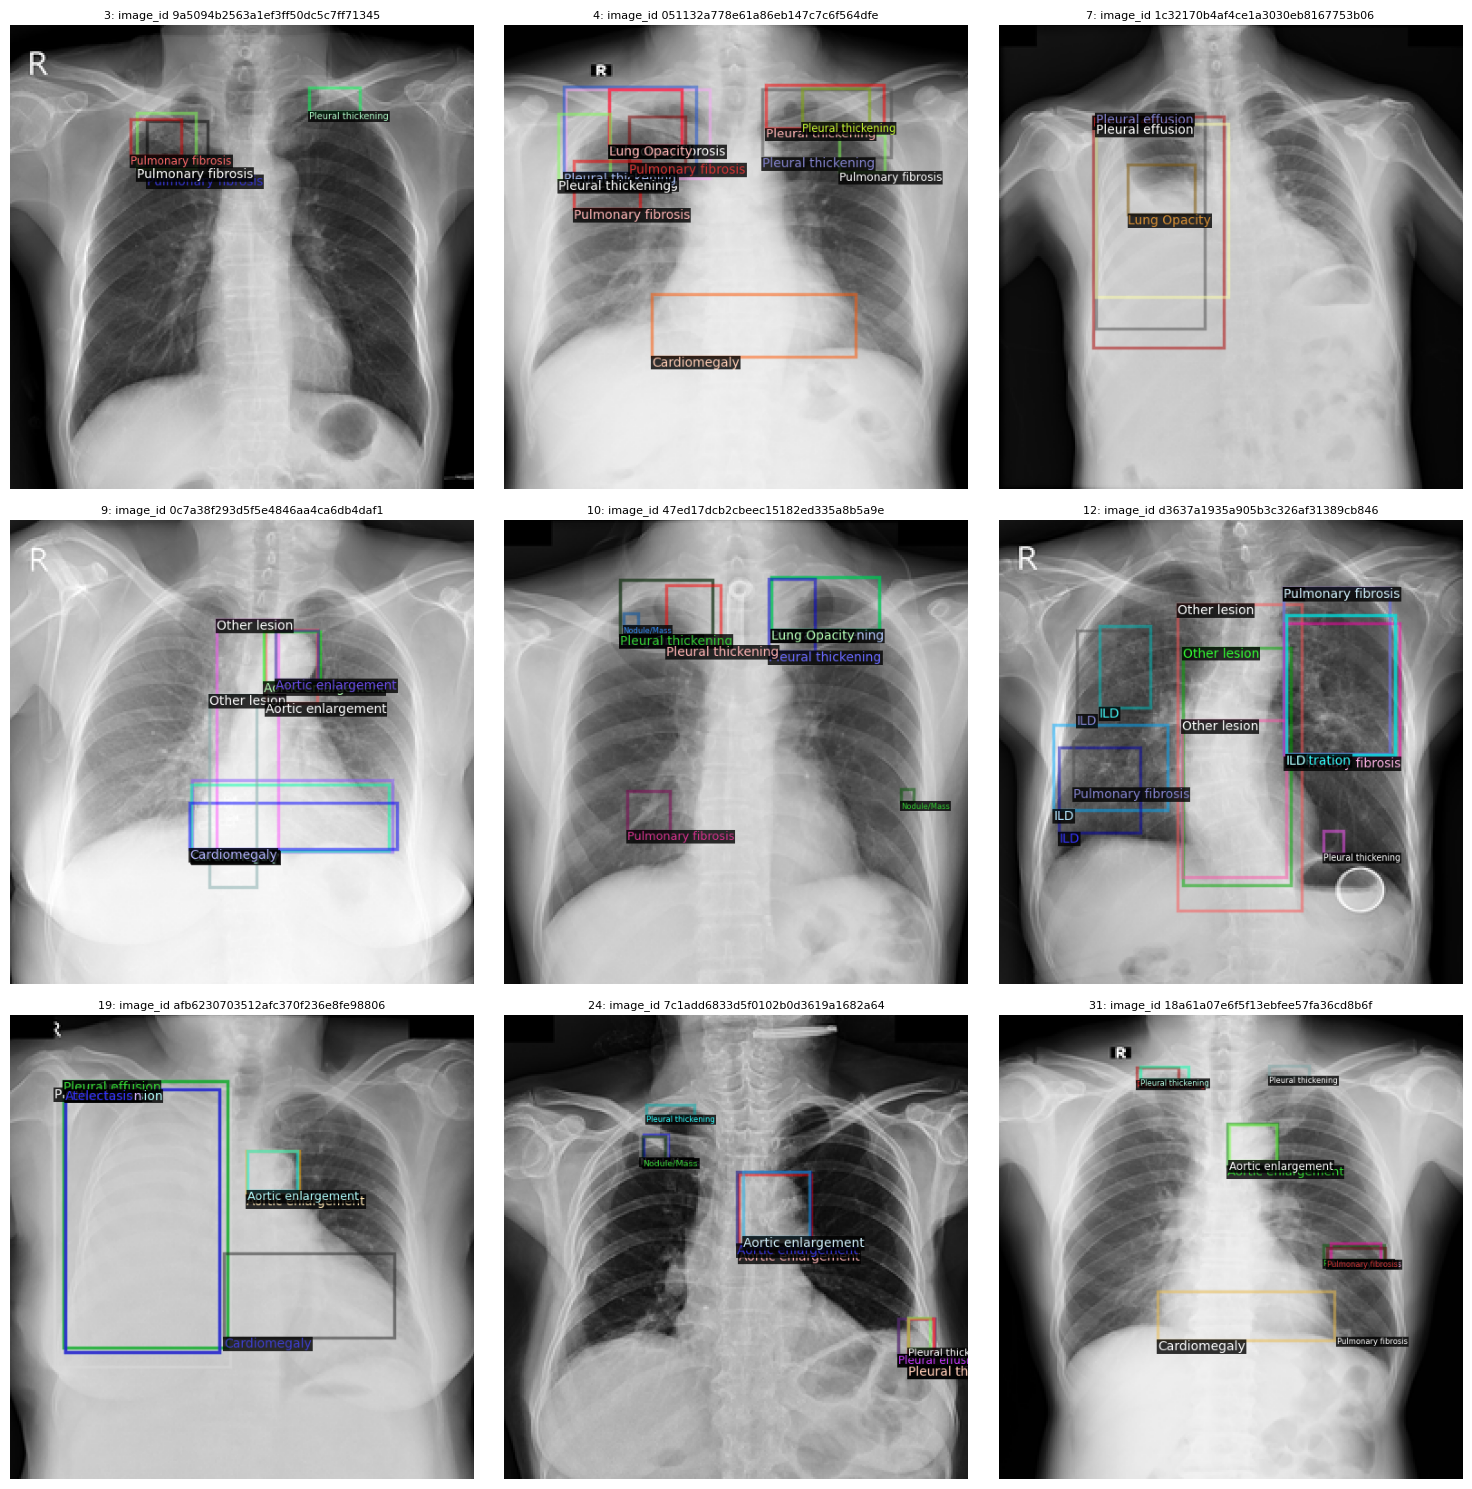

In [92]:
from detectron2.utils.visualizer import Visualizer ,ColorMode
from detectron2.data import MetadataCatalog

def visualize_anomalies(dataset_dicts, train_df, imgdir, thing_classes, num_samples=9, label_font_size=10):
    anomaly_image_ids = train_df.query("class_id != 14")["image_id"].unique()
    train_meta = pd.read_csv(imgdir / "Original_Image_Dimensions.csv")
    anomaly_inds = np.argwhere(train_meta["image_id"].isin(anomaly_image_ids).values)[:, 0]
    
    vinbigdata_metadata = MetadataCatalog.get("vinbigdata_train").set(thing_classes=thing_classes)
    
    cols = 3
    rows = num_samples // cols if num_samples % cols == 0 else (num_samples // cols) + 1
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))  # Increase plot size
    axes = axes.flatten()
    text_scale=0.8

    for index, anom_ind in enumerate(anomaly_inds[:num_samples]):
        ax = axes[index]
        d = dataset_dicts[anom_ind]
        img = cv2.imread(d["file_name"])
        
        # Initialize the visualizer with the `text_scale` parameter
        visualizer = Visualizer(img[:, :, ::-1], metadata=vinbigdata_metadata, scale=2, instance_mode=ColorMode.IMAGE)
        out = visualizer.draw_dataset_dict(d)
        
        ax.imshow(out.get_image()[:, :, ::-1])
        ax.axis('off')
        if index < len(anomaly_image_ids):
            ax.set_title(f"{anom_ind}: image_id {anomaly_image_ids[index]}", fontsize=int(10 * text_scale))
        else:
            ax.set_title(f"{anom_ind}", fontsize=int(10 * text_scale))

    
    for ax in axes[num_samples:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

imgdir = Path("Proc_data")
dataset_dicts = load_data(imgdir, train_df, flags.debug)

# Example usage
visualize_anomalies(dataset_dicts, train_df, imgdir, thing_classes, num_samples=9)


# Main Model Training Technics

Import Relevant Libraries For Training

In [99]:
from detectron2.engine import DefaultTrainer, HookBase
from detectron2.data import  build_detection_train_loader, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator
import albumentations as A
import copy
import datetime
import logging
import time
import matplotlib.pyplot as plt
import detectron2.utils.comm as comm
from detectron2.engine.hooks import HookBase
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import detection_utils as utils

I've integrated an AlbumentationsMapper that utilizes the augmentations from the albumentations library. Note that I was inspired from the official exemple in detectron2 official page , see " https://github.com/facebookresearch/detectron2/tree/main"

In [100]:
class AlbumentationsMapper:
    """Mapper which uses `albumentations` augmentations"""
    def __init__(self, cfg, is_train: bool = True):
        aug_kwargs = cfg.aug_kwargs
        aug_list = [
        ]
        if is_train:
            aug_list.extend([getattr(A, name)(**kwargs) for name, kwargs in aug_kwargs.items()])
        self.transform = A.Compose(
            aug_list, bbox_params=A.BboxParams(format="pascal_voc", label_fields=["category_ids"])
        )
        self.is_train = is_train

        mode = "training" if is_train else "inference"
        print(f"[AlbumentationsMapper] Augmentations used in {mode}: {self.transform}")

    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        image = utils.read_image(dataset_dict["file_name"], format="BGR")

        # aug_input = T.AugInput(image)
        # transforms = self.augmentations(aug_input)
        # image = aug_input.image

        prev_anno = dataset_dict["annotations"]
        bboxes = np.array([obj["bbox"] for obj in prev_anno], dtype=np.float32)
        # category_id = np.array([obj["category_id"] for obj in dataset_dict["annotations"]], dtype=np.int64)
        category_id = np.arange(len(dataset_dict["annotations"]))

        transformed = self.transform(image=image, bboxes=bboxes, category_ids=category_id)
        image = transformed["image"]
        annos = []
        for i, j in enumerate(transformed["category_ids"]):
            d = prev_anno[j]
            d["bbox"] = transformed["bboxes"][i]
            annos.append(d)
        dataset_dict.pop("annotations", None)  # Remove unnecessary field.

        # if not self.is_train:
        #     # USER: Modify this if you want to keep them for some reason.
        #     dataset_dict.pop("annotations", None)
        #     dataset_dict.pop("sem_seg_file_name", None)
        #     return dataset_dict

        image_shape = image.shape[:2]  # h, w
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
        instances = utils.annotations_to_instances(annos, image_shape)
        dataset_dict["instances"] = utils.filter_empty_instances(instances)
        return dataset_dict
    
class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader

    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)

        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        # self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        # return losses
        return mean_loss

    def _get_loss(self, data):
        # How loss is calculated on train_loop
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced

    def after_step(self):
        next_iter = int(self.trainer.iter) + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            mean_loss = self._do_loss_eval()
            self.trainer.storage.put_scalars(validation_loss=mean_loss)
            print("validation do loss eval", mean_loss)
        else:
            pass
            # self.trainer.storage.put_scalars(timetest=11)

MyTrainer enhances the build_evaluator method from Detectron2's DefaultTrainer to enable evaluation on the validation dataset.

build_train_loader & build_test_loader: These methods specify the creation of DataLoaders for training and validation data, respectively. They utilize AlbumentationMapper to incorporate custom augmentation processes.

build_evaluator: This method outlines the construction of the Evaluator, opting for COCOEvaluator in this implementation.

build_hooks: Defines the arrangement of hooks. The LossEvalHook is placed before the evaluator to ensure smooth operation

In [101]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg, sampler=None):
        return build_detection_train_loader(
            cfg, mapper=AlbumentationsMapper(cfg, True), sampler=sampler
        )

    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(
            cfg, dataset_name, mapper=AlbumentationsMapper(cfg, False)
        )

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        # return PascalVOCDetectionEvaluator(dataset_name)  # not working
        return COCOEvaluator(dataset_name, ("bbox",), False, output_dir=output_folder)


    def build_hooks(self):
        hooks = super(MyTrainer, self).build_hooks()
        cfg = self.cfg
        if len(cfg.DATASETS.TEST) > 0:
            loss_eval_hook = LossEvalHook(
                cfg.TEST.EVAL_PERIOD,
                self.model,
                MyTrainer.build_test_loader(cfg, cfg.DATASETS.TEST[0]),
            )
            hooks.insert(-1, loss_eval_hook)

        return hooks

# Begin the Training Procedure

In [102]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.config.config import CfgNode as CN

# Assuming thing_classes is defined somewhere in your code as a list of class names
# thing_classes = [...]
split_mode = flags.split_mode
cfg = get_cfg()
cfg.aug_kwargs = CN(flags.aug_kwargs)

original_output_dir = cfg.OUTPUT_DIR
cfg.OUTPUT_DIR = str(outdir)
print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = ("vinbigdata_train",)
if split_mode == "all_train":
    cfg.DATASETS.TEST = ()
else:
    cfg.DATASETS.TEST = ("vinbigdata_valid",)
    cfg.TEST.EVAL_PERIOD = flags.eval_period

cfg.DATALOADER.NUM_WORKERS = flags.num_workers
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
cfg.SOLVER.IMS_PER_BATCH = flags.ims_per_batch
cfg.SOLVER.LR_SCHEDULER_NAME = flags.lr_scheduler_name
cfg.SOLVER.BASE_LR = flags.base_lr  # pick a good LR
cfg.SOLVER.MAX_ITER = flags.iter
cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = flags.roi_batch_size_per_image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
# NOTE: this config means the number of classes,
# but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


cfg.OUTPUT_DIR ./output -> results


In [56]:
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/16 00:53:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (15, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (15,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (56, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (56,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias

[03/16 00:53:28 d2.engine.train_loop]: Starting training from iteration 0
[03/16 00:53:33 d2.utils.events]:  eta: 0:13:31  iter: 19  total_loss: 4.065  loss_cls: 2.452  loss_box_reg: 0.04296  loss_rpn_cls: 1.458  loss_rpn_loc: 0.1138    time: 0.0808  last_time: 0.0780  data_time: 0.1704  last_data_time: 0.0007   lr: 1.9516e-05  max_mem: 1190M
[03/16 00:53:35 d2.utils.events]:  eta: 0:13:26  iter: 39  total_loss: 3.087  loss_cls: 1.796  loss_box_reg: 0.05754  loss_rpn_cls: 0.9967  loss_rpn_loc: 0.1622    time: 0.0815  last_time: 0.0768  data_time: 0.0009  last_data_time: 0.0012   lr: 3.9007e-05  max_mem: 1190M
[03/16 00:53:36 d2.utils.events]:  eta: 0:13:06  iter: 59  total_loss: 1.203  loss_cls: 0.4501  loss_box_reg: 0.08269  loss_rpn_cls: 0.4523  loss_rpn_loc: 0.1366    time: 0.0790  last_time: 0.0717  data_time: 0.0008  last_data_time: 0.0009   lr: 5.8497e-05  max_mem: 1190M
[03/16 00:53:38 d2.utils.events]:  eta: 0:12:57  iter: 79  total_loss: 0.9527  loss_cls: 0.2924  loss_box_reg:

#  Visualize Analyse Results Of The Training 

In [94]:
metrics_df = pd.read_json("results/det/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf

,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,fast_rcnn/fg_cls_accuracy,iteration,loss_box_reg,loss_cls,loss_rpn_cls,loss_rpn_loc,...,bbox/AP-Pleural effusion,bbox/AP-Pleural thickening,bbox/AP-Pneumothorax,bbox/AP-Pulmonary fibrosis,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,validation_loss
0,0.005719,1040.293054,0.015625,0.000000,0.067412,19,0.039103,2.696530,1.450480,0.125123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.005517,1039.150091,0.921387,1.000000,0.000000,39,0.081317,2.039909,0.702972,0.132502,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.005131,1005.394550,0.963379,1.000000,0.000000,59,0.102868,0.575413,0.481145,0.142517,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.004772,986.728200,0.969238,1.000000,0.000000,79,0.072173,0.253736,0.408208,0.133887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.005360,976.962947,0.960938,1.000000,0.000000,99,0.098488,0.261739,0.277952,0.112009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,0.011247,5.971869,0.939453,0.482553,0.441558,9939,0.191580,0.191835,0.128104,0.073967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,0.011219,3.980420,0.925293,0.449723,0.352148,9959,0.270929,0.225749,0.106291,0.100998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,0.005641,1.990707,0.951172,0.384080,0.542812,9979,0.186627,0.164589,0.114213,0.090596,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
499,0.010112,0.000000,0.989258,0.297872,0.702128,9999,0.200367,0.157185,0.107828,0.067221,...,15.586372,3.093841,0.0,8.524244,14.490787,18.409132,13.653952,10.978324,4.835033,0.293393


Visualization of the model’s learning progression over iterations, illustrating the behavior of training and validation losses. 

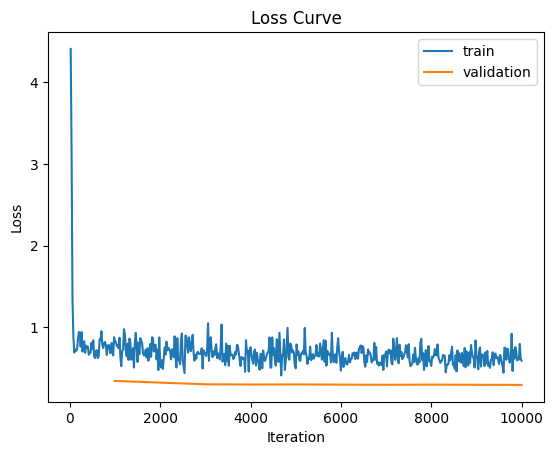

<Figure size 640x480 with 0 Axes>

In [96]:
fig, ax = plt.subplots()

# Filter out rows where 'total_loss' is NaN
total_loss_df = mdf1[~mdf["total_loss"].isna()]
ax.plot(total_loss_df["iteration"], total_loss_df["total_loss"], c="C0", label="train")

# Check if 'validation_loss' column exists and has non-NaN values
if "validation_loss" in mdf.columns and not mdf["validation_loss"].isna().all():
    validation_loss_df = mdf[~mdf["validation_loss"].isna()]
    ax.plot(validation_loss_df["iteration"], validation_loss_df["validation_loss"], c="C1", label="validation")

ax.legend()
ax.set_title("Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()
# Assuming outdir is a Path object pointing to your output directory
plt.savefig(outdir / "loss_curve.png")


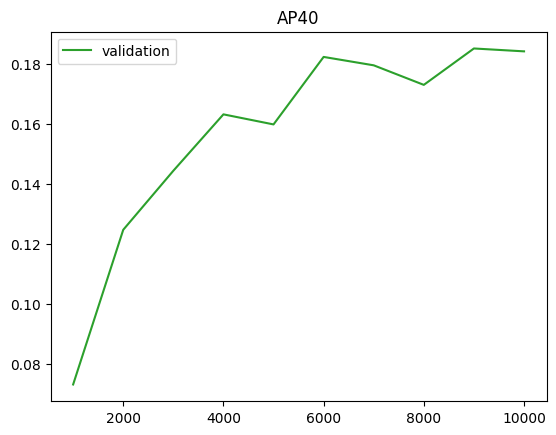

<Figure size 640x480 with 0 Axes>

In [97]:
fig, ax = plt.subplots()
mdf3 = mdf[~mdf["bbox/AP75"].isna()]
ax.plot(mdf3["iteration"], mdf3["bbox/AP75"] / 100., c="C2", label="validation")

ax.legend()
ax.set_title("AP40")
plt.show()
plt.savefig(outdir / "AP40.png")

# Visualization Of The Trained Data After Augmentation

[AlbumentationsMapper] Augmentations used in training: Compose([
  HorizontalFlip(always_apply=False, p=0.5),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.15000000000000002, 0.1499999999999999), rotate_limit=(-10, 10), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box'),
  RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'min_width': 0.0, 'min_height': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={}, is_check_shapes=True)
[03/16 02:25:45 d2.data.build]: Removed 8505 images with no usable annotations. 3495 images left.
[03/16 02:25:45 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'

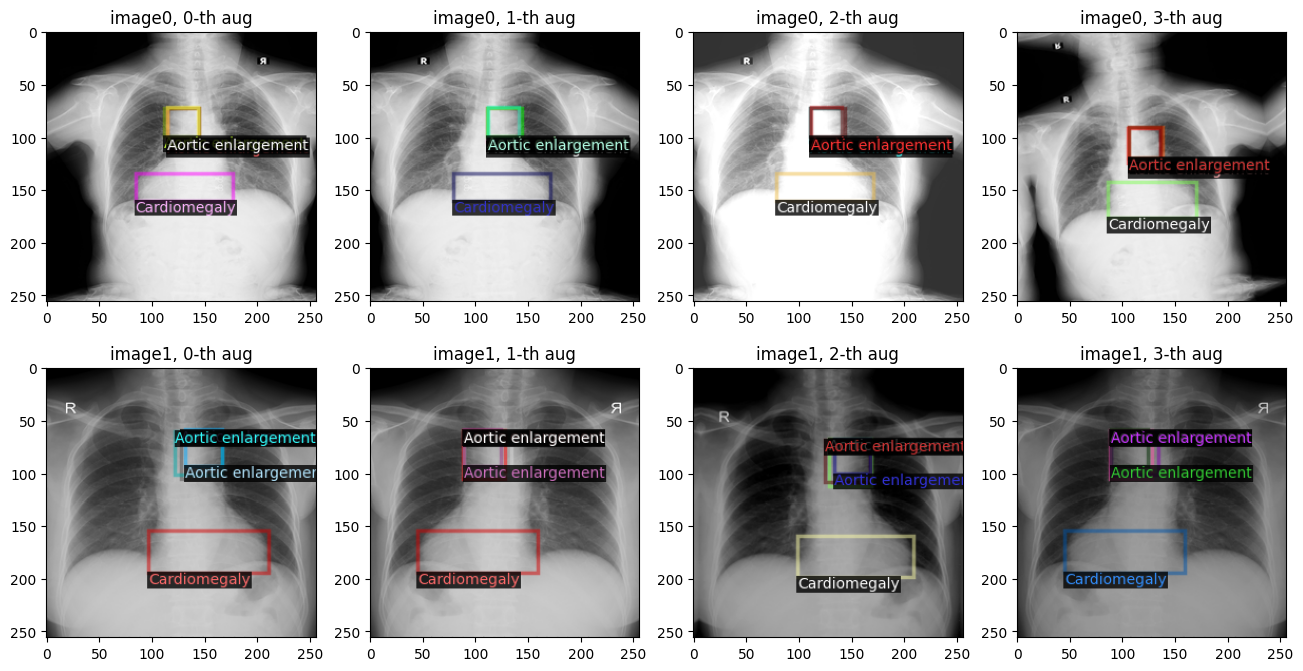

In [107]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data.samplers import TrainingSampler

vinbigdata_metadata = MetadataCatalog.get("vinbigdata_train").set(thing_classes=thing_classes)


n_images = 2
n_aug = 4

fig, axes = plt.subplots(n_images, n_aug, figsize=(16, 8))

# Ref https://github.com/facebookresearch/detectron2/blob/22b70a8078eb09da38d0fefa130d0f537562bebc/tools/visualize_data.py#L79-L88
for i in range(n_aug):
    sampler = TrainingSampler(len(dataset_dicts), shuffle=False)
    train_vis_loader = MyTrainer.build_train_loader(
        cfg, sampler=sampler
    )  # For visualization...
    for batch in train_vis_loader:
        for j, per_image in enumerate(batch):
            ax = axes[j, i]

            img_arr = per_image["image"].cpu().numpy().transpose((1, 2, 0))
            visualizer = Visualizer(
                img_arr[:, :, ::-1], metadata=vinbigdata_metadata, scale=1.0
            )
            target_fields = per_image["instances"].get_fields()
            labels = [
                vinbigdata_metadata.thing_classes[i] for i in target_fields["gt_classes"]
            ]
            out = visualizer.overlay_instances(
                labels=labels,
                boxes=target_fields.get("gt_boxes", None),
                masks=target_fields.get("gt_masks", None),
                keypoints=target_fields.get("gt_keypoints", None),
            )
            # out = visualizer.draw_dataset_dict(per_image)

            img = out.get_image()[:, :, ::-1]
            filepath = str(outdir / f"vinbigdata_{j}_aug{i}.jpg")
            cv2.imwrite(filepath, img)
            print(f"Visualization img {img_arr.shape} saved in {filepath}")
            ax.imshow(img)
            ax.set_title(f"image{j}, {i}-th aug")
        break


